**Importing the libraries:**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


**Check** https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=0oj0gTIy4k60

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-03-21 06:19:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  87.8MB/s    in 0.7s    

2019-03-21 06:19:48 (87.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



**Extracting the directory of the main file:**

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

**Defining the directories for training and validation sets of cats and dogs:**

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

**Defining file names for training and validation sets for cats and dogs:**

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

validation_cat_fnames = os.listdir(validation_cats_dir)
validation_dog_fnames = os.listdir(validation_dogs_dir)

['cat.272.jpg', 'cat.138.jpg', 'cat.238.jpg', 'cat.522.jpg', 'cat.583.jpg', 'cat.812.jpg', 'cat.561.jpg', 'cat.533.jpg', 'cat.102.jpg', 'cat.33.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


**Printing number of images in training and validation sets of cats and dogs:**

In [6]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))
print('Total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('Total validation dog images: ', len(os.listdir(validation_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500


**Creating training and validation sets of cats and dogs, containing images:**

In [0]:
train_cat_imgs = []
train_dog_imgs = []
val_cat_imgs = []
val_dog_imgs = []

for i in range(len(train_cat_fnames)):
  current_cat = cv2.imread(train_cats_dir + "/" + train_cat_fnames[i], cv2.COLOR_BGR2RGB)
  current_dog = cv2.imread(train_dogs_dir + "/" + train_dog_fnames[i], cv2.COLOR_BGR2RGB)
  resized_cat = cv2.resize(current_cat, (100, 100),
                           interpolation = cv2.INTER_AREA)
  resized_dog = cv2.resize(current_dog, (100, 100),
                           interpolation = cv2.INTER_AREA)
  train_cat_imgs.append(resized_cat)
  train_dog_imgs.append(resized_dog)
  
final_train_cats = np.array(train_cat_imgs)
final_train_dogs = np.array(train_dog_imgs)

for i in range(len(validation_cat_fnames)):
  current_cat = cv2.imread(validation_cats_dir + "/" + validation_cat_fnames[i], cv2.COLOR_BGR2RGB)
  current_dog = cv2.imread(validation_dogs_dir + "/" + validation_dog_fnames[i], cv2.COLOR_BGR2RGB)
  resized_cat = cv2.resize(current_cat, (100, 100),
                           interpolation = cv2.INTER_AREA)
  resized_dog = cv2.resize(current_dog, (100, 100),
                           interpolation = cv2.INTER_AREA)
  val_cat_imgs.append(resized_cat)
  val_dog_imgs.append(resized_dog)
  
final_val_cats = np.array(val_cat_imgs)
final_val_dogs = np.array(val_dog_imgs)

**Printing 3 random images of cats and dogs from their respective training sets:**

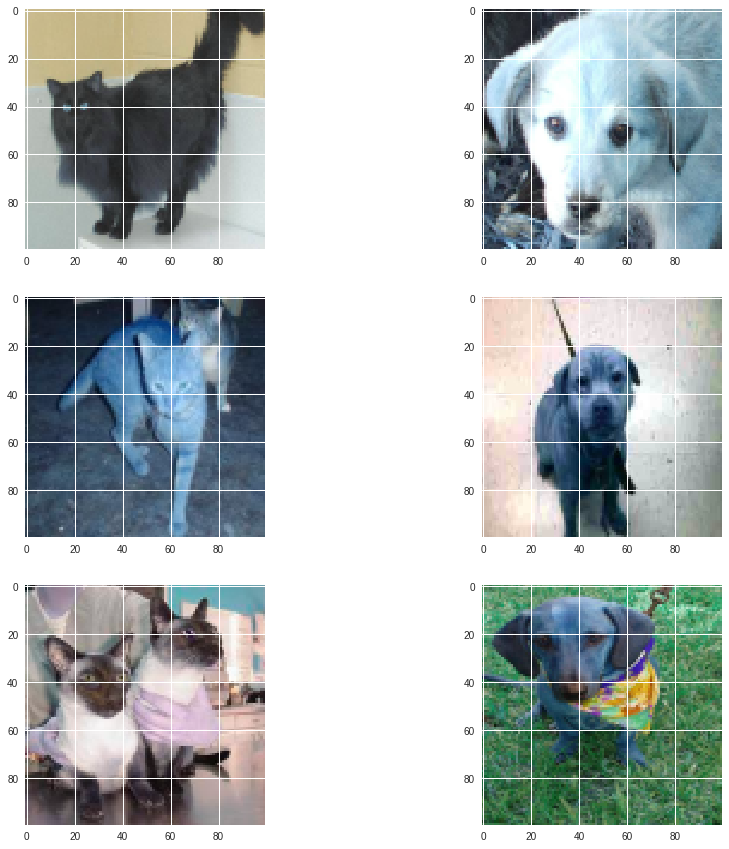

In [8]:
n_examples = 3

plt.figure(figsize = (15, 15))
i = 1

for _ in range(n_examples):
  image_cat = final_train_cats[np.random.randint(len(final_train_cats))]
  plt.subplot(3, 2, i)
  _ = plt.imshow(image_cat)
  i += 1
  
  image_dog = final_train_dogs[np.random.randint(len(final_train_dogs))]
  plt.subplot(3, 2, i)
  i += 1
  _ = plt.imshow(image_dog)

plt.show()

**We'll be using a batch generator so that we don't have to load all images in memory:**

In [0]:
def batchgen(cats, dogs, batch_size, img_size = 100):
  
  # Create empty numpy arrays
  batch_images = np.zeros((batch_size, img_size, img_size, 3))
  batch_label = np.zeros(batch_size)
  
  # Custom batch generator
  while 1:
    n = 0
    while n < batch_size:
      # Randomly pick a dog or cat image
      if np.random.randint(2) == 1:
        i = np.random.randint(len(dogs))
        if dogs[i] is None:
          break
        img = dogs[i]
        y = 1
      
      else:
        i = np.random.randint(len(cats))
        if cats[i] is None:
          break
        img = cats[i]
        y = 0
        
      batch_images[n] = img
      batch_label[n] = y
      n += 1
      
    yield batch_images, batch_label  

**Next, we define a function that creates a model given parameters for the stride and padding:**

In [0]:
def create_model(stride = 1, padding = 'same', img_size = 100):
  
  # Define architecture
  model = Sequential()
  model.add(Lambda(lambda x: (x / 255.) - 0.5, 
                   input_shape = (img_size, img_size, 3)))
  model.add(Conv2D(32, (3, 3), activation = 'relu',
                   padding = padding, strides = stride))
  model.add(Conv2D(32, (3, 3), activation = 'relu',
                   padding = padding, strides = stride))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, (3, 3), activation = 'relu',
                   padding = padding, strides = stride))
  model.add(Conv2D(64, (3, 3), activation = 'relu',
                   padding = padding, strides = stride))
  
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))
  
  opt = Adam(0.001)
  
  model.compile(loss = 'binary_crossentropy',
                optimizer = opt,
                metrics = ['binary_accuracy'])
  
  return model

**Now we can define a model for each setting, and we extract the number of trainable parameters:**

In [11]:
img_size = 100

models = []

for stride in [1, 2]:
  for padding in ['same', 'valid']:
    model = create_model(stride, padding, img_size)
    pars = model.count_params()
    models.append(dict({
        'setting': '{}_{}'.format(stride, padding),
        'model': model,
        'parameters': pars
    }))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**To output the scheme of a model, we can use the following:**

In [12]:
models[0]['model'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
__________

**To use early stopping, we define a callback as follows:**

In [0]:
callbacks = [EarlyStopping(monitor = 'val_binary_accuracy',
                           patience = 5)]

**In the next step, we will train our models and store the results:**

In [14]:
n_epochs = 500
batch_size = 512

validation_steps = round((len(final_val_dogs) + len(final_val_cats)) / batch_size)
steps_per_epoch = round((len(final_train_dogs) + len(final_train_cats)) / batch_size)

train_generator = batchgen(final_train_dogs, final_train_cats,
                           batch_size, img_size)
val_generator = batchgen(final_val_dogs, final_val_cats,
                         batch_size, img_size)

history = []

for i in range(len(models)):
  print(models[i])
  history.append(
    models[i]['model'].
    fit_generator(train_generator,
                  steps_per_epoch = steps_per_epoch,
                  epochs = n_epochs,
                  validation_data = val_generator,
                  validation_steps = validation_steps,
                  callbacks = callbacks))

{'setting': '1_same', 'model': <keras.engine.sequential.Sequential object at 0x7f2cdae5fba8>, 'parameters': 10305697}
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
4/4 [==============================] - 13s 3s/step - loss: 0.9512 - binary_accuracy: 0.5264 - val_loss: 0.6987 - val_binary_accuracy: 0.4883
Epoch 2/500
4/4 [==============================] - 4s 918ms/step - loss: 0.6978 - binary_accuracy: 0.5156 - val_loss: 0.6931 - val_binary_accuracy: 0.5088
Epoch 3/500
4/4 [==============================] - 4s 911ms/step - loss: 0.6931 - binary_accuracy: 0.5049 - val_loss: 0.6931 - val_binary_accuracy: 0.5146
Epoch 4/500
4/4 [==============================] - 4s 914ms/step - loss: 0.6932 - binary_accuracy: 0.4990 - val_loss: 0.6931 - val_binary_accuracy: 0.5107
Epoch 5/500
4/4 [==============================] - 4s 906ms/step - loss: 0.6931 - binary_accuracy: 0.5029 - val_loss: 0.6931 - val_binary_accuracy: 0.5020
Epoch 6/500
4/4 [==============================] - 4s 912ms/s

**Let's visualize the results:**

Max accuracy model 1_same: 0.5146484375


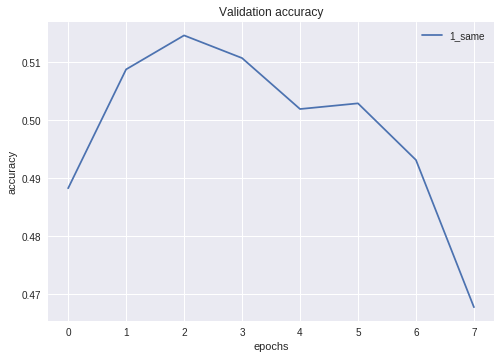

Max accuracy model 1_valid: 0.5439453125


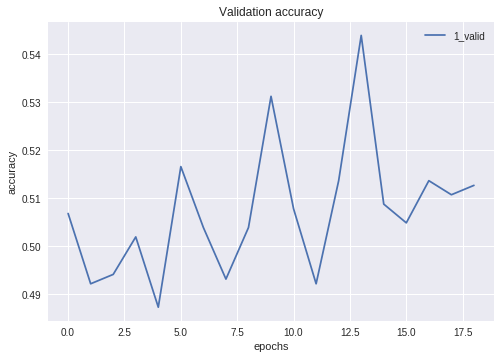

Max accuracy model 2_same: 0.5283203125


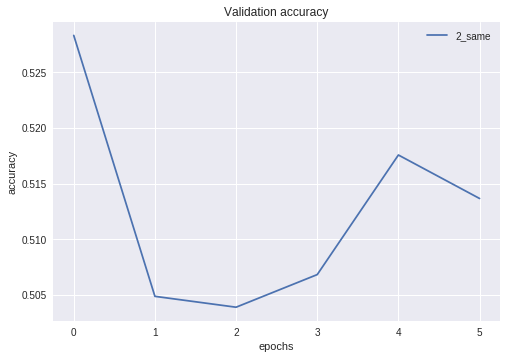

Max accuracy model 2_valid: 0.5361328125


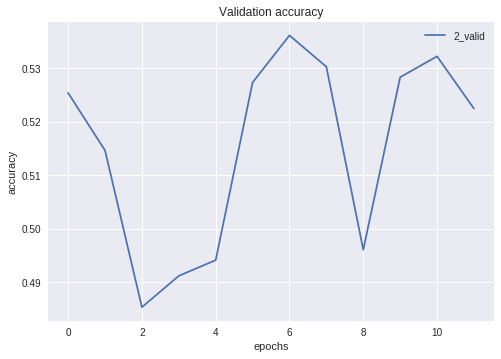

In [18]:
for i in range(len(models)):
  plt.plot(range(len(history[i].history['val_binary_accuracy'])),
           history[i].history['val_binary_accuracy'],
           label = models[i]['setting'])
  print('Max accuracy model {}: {}'.format(models[i]['setting'],
                                           max(history[i].history['val_binary_accuracy'])))
  plt.title('Validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  
  ## Performance comparison with different settings for padding
  ## and strides.

**Printing the max accuracies of the models, and the number of parameters of each:**

Max accuracy model 1_same: 0.5146484375 (#parameters: 10305697)
Max accuracy model 1_valid: 0.5439453125 (#parameters: 7995553)
Max accuracy model 2_same: 0.5283203125 (#parameters: 102561)
Max accuracy model 2_valid: 0.5361328125 (#parameters: 82081)


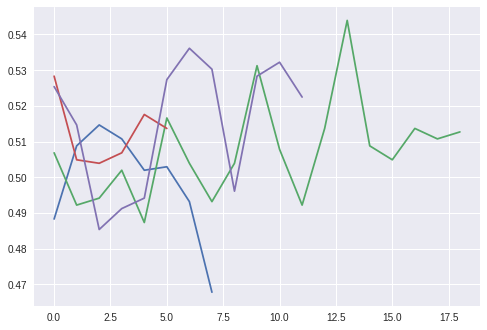

In [16]:
for i in range(len(models)):
  plt.plot(range(len(history[i].history['val_binary_accuracy'])),
           history[i].history['val_binary_accuracy'],
           label = models[i]['setting'])
  print('Max accuracy model {}: {} (#parameters: {})'.format(models[i]['setting'],
                                                             max(history[i].history['val_binary_accuracy']),
                                                             models[i]['parameters']))